<a href="https://colab.research.google.com/github/Priyanka-code-sys/Thesis_Priyanka/blob/main/bi_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

In [2]:
#set the memory growth for the gpu
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
#define the mirror stragy to use all gpus
strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [4]:
!wget https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_multilingual_UK_v1_00.tsv.gz
!wget https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_multilingual_FR_v1_00.tsv.gz

--2021-12-15 09:55:01--  https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_multilingual_UK_v1_00.tsv.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.88.37
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.88.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349370868 (333M) [application/x-gzip]
Saving to: ‘amazon_reviews_multilingual_UK_v1_00.tsv.gz’

amazon_reviews_mult 100%[===================>] 333.19M  49.5MB/s    in 6.7s    

2021-12-15 09:55:08 (49.5 MB/s) - ‘amazon_reviews_multilingual_UK_v1_00.tsv.gz’ saved [349370868/349370868]

--2021-12-15 09:55:08--  https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_multilingual_FR_v1_00.tsv.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.205.136
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.205.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70583516 (67M) [application/x-gzip]
Saving to: ‘amazon_reviews_multilingual_FR

In [5]:
#load the pandas dataframe
#load the pandas dataframe
df_en = pd.read_csv('amazon_reviews_multilingual_UK_v1_00.tsv.gz',delimiter = '\t', quoting = 3)
df_fr = pd.read_csv('amazon_reviews_multilingual_FR_v1_00.tsv.gz',delimiter = '\t', quoting = 3)

In [7]:
#remove the un-necessary rows and columns
df_en = df_en.loc[:,['review_headline','review_body','star_rating']]
df_fr = df_fr.loc[:,['review_headline','review_body','star_rating']]


In [8]:
#find the length of both the datasets
print(len(df_en.index))
print(len(df_fr.index))

1707494
254080


In [9]:
#take 250k review from each dataset (to balance english and french dataset)
df_en = sklearn.utils.shuffle(df_en)
df_en = df_en[:250000]
df_fr = sklearn.utils.shuffle(df_fr)
df_fr = df_fr[:250000]

In [10]:
#combine the dataset into single dataset
df = pd.concat([df_en,df_fr])

In [11]:
df.head(5)

,review_headline,review_body,star_rating
648587,Five Stars,So very clearly and logically explained.,5
121989,recommend to anyone,"Great game, would definitely recommend downloa...",4
1036257,Fantastic read,I loved this book - a gripping read from start...,5
1662068,Beyond amazing,"While some people don't like the story, my fam...",5
326821,Brilliant,"Simply put, brilliant!<br /><br />A great, eas...",5


In [12]:
df.tail(5)

,review_headline,review_body,star_rating
243310,TRIVIUM évolue encore !,Je possède tous les albums de TRIVIUM et au mo...,4
238378,Pas d'accord!,J'attendais tellement du dernier Terry Gilliam...,2
226633,Le bible pour faire du pain,"Il faut avoir le temps, mais le livre est inst...",5
209220,Haletant,Super livre ! Passionnant et haletant jusqu'&a...,4
85796,QUALITE VIDEO,"Bonne série, mais pour du blu ray pas mal de p...",4


In [13]:
#shuffle the dataset with sklearn
df = sklearn.utils.shuffle(df)

In [14]:
df.head(5)

,review_headline,review_body,star_rating
1267927,Five Stars,Strange but good,5
225826,superbe album,enfin un album de satriani qui fait la part be...,5
54412,Très mimi,"Très sympa petit film, pour enfant ou même adu...",5
14588,Very nice read. Turned out differently to what...,Very nice read. Turned out differently to wha...,4
249766,incortounable,Ce DVD est indispensable pour la DVD thèque de...,5


In [15]:
df.tail(5)

,review_headline,review_body,star_rating
1206719,A Decent Enough Ride But...,On the whole I enjoyed Cloverfield. It is a we...,3
10005,Vraiment pas à rougir des grandes marques ...,Mouvement ETA 24 bijoux 100% Made in Suisse .....,5
241778,Bon album,Bon produit que j'attendais avec impatience.<b...,4
80662,jamais reçu,"Commandé mais jamais reçu , ou laissé dans un ...",1
550777,Classic Songs....Stunning Voice,"I ( like many others, no doubt) bought the alb...",5


In [16]:
#combine the review heading and review body
df['review'] = df['review_headline'] + ' ' + df['review_body']
df = df.loc[:,['review','star_rating']]

In [17]:
df.head(5)

,review,star_rating
1267927,Five Stars Strange but good,5
225826,superbe album enfin un album de satriani qui f...,5
54412,"Très mimi Très sympa petit film, pour enfant o...",5
14588,Very nice read. Turned out differently to what...,4
249766,incortounable Ce DVD est indispensable pour la...,5


In [18]:
#clean the text using (convert into lower case + remove special chars)
df['review'] = df['review'].str.lower()


In [19]:
df.head(5)

,review,star_rating
1267927,five stars strange but good,5
225826,superbe album enfin un album de satriani qui f...,5
54412,"très mimi très sympa petit film, pour enfant o...",5
14588,very nice read. turned out differently to what...,4
249766,incortounable ce dvd est indispensable pour la...,5


In [20]:
df['review'] =df['review'].str.replace(r'[^a-zA-Z0-9\w\sàâäôéèëêïîçùûüÿæœÀÂÄÔÉÈËÊÏÎŸÇÙÛÜÆŒ]+',' ',regex=True)

In [21]:
df.head(5)

,review,star_rating
1267927,five stars strange but good,5
225826,superbe album enfin un album de satriani qui f...,5
54412,très mimi très sympa petit film pour enfant o...,5
14588,very nice read turned out differently to what...,4
249766,incortounable ce dvd est indispensable pour la...,5


In [22]:
#balance the number dataset for same number of review for each rating
df_five = df[df['star_rating']==5]
df_four = df[df['star_rating']==4]
df_three = df[df['star_rating']==3]
df_two = df[df['star_rating']==2]
df_one = df[df['star_rating']==1]


In [ ]:
#get the length of each reviews
print(len(df_five.index))
print(len(df_four.index))
print(len(df_three.index))
print(len(df_two.index))
print(len(df_one.index))

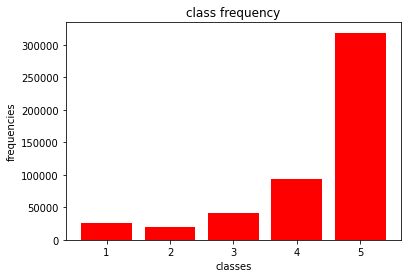

In [24]:
#un balanced dataset
y = [len(df_one.index),len(df_two.index),len(df_three.index),len(df_four.index),len(df_five.index)]
x = [1,2,3,4,5]
plt.bar(x,y,color='red',label='data-balance')
plt.title('class frequency')
plt.xlabel('classes')
plt.ylabel('frequencies')
plt.show()

In [25]:
#taking 20k from each review
sample = 20000
df = pd.concat([df_five[:sample],df_four[:sample],df_three[:sample],df_two[:sample],df_one[:sample]])

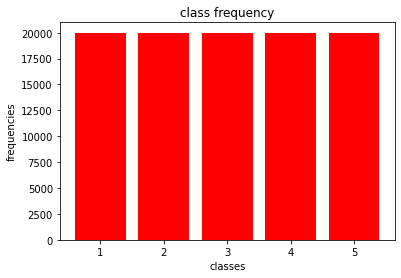

In [28]:
#balance the number dataset for same number of review for each rating
df_five = df[df['star_rating']==5]
df_four = df[df['star_rating']==4]
df_three = df[df['star_rating']==3]
df_two = df[df['star_rating']==2]
df_one = df[df['star_rating']==1]
#un balanced dataset
y = [len(df_one.index),len(df_two.index),len(df_three.index),len(df_four.index),len(df_five.index)]
x = [1,2,3,4,5]
plt.bar(x,y,color='red',label='data-balance')
plt.title('class frequency')
plt.xlabel('classes')
plt.ylabel('frequencies')
plt.show()

In [27]:
#total length of the dataset
print(len(df.index))

100000


In [29]:
#scale the ratings between 0-1
df['star_rating'] = df['star_rating']/5

In [30]:
df.head(5)

,review,star_rating
1267927,five stars strange but good,1.0
225826,superbe album enfin un album de satriani qui f...,1.0
54412,très mimi très sympa petit film pour enfant o...,1.0
249766,incortounable ce dvd est indispensable pour la...,1.0
842031,great entertainment and excitement for a very ...,1.0


In [31]:
#shuffle the dataset again
df = sklearn.utils.shuffle(df)
df.head(10)

,review,star_rating
35692,dvd lawrence d arabie image superbe ce qui fa...,1.0
723041,a soulless film about special fx this movie lo...,0.4
1385285,four stars not bad,0.8
78951,décoiffant quelle vie les commentateurs précé...,0.6
180172,bilan des débuts de carrière après avoir franc...,0.6
66852,très bon jeu mon enfant de 5 ans adore tous le...,0.8
1577351,i wonder why i bought this couldn t stand anot...,0.2
145675,petit pratique et directe au but c est la res...,0.8
131824,c est une calculatrice bof c est une calculat...,0.6
784389,ok but not outrageous this film does show its...,0.6


In [32]:
#save the transformed dataset
import pickle

df.to_pickle("./dataset.pkl")

In [33]:
#sepearate the dataframe into text reviews and ratings.
VOCAB_SIZE = 50000
with strategy.scope():
    encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

In [34]:
#adap the vocabulary on the data-set
X = df['review'].map(lambda x:str(x))

In [35]:
print(type(X.values))
print(X.values.shape)
print(X.values.dtype)
X_val = X.values
print(X_val[:3])

<class 'numpy.ndarray'>
(100000,)
object
['dvd lawrence d arabie image superbe  ce qui fait qu au final br  le film m a paru bien plus court qu avec la version dvd  br  nouvelle découverte des détails oubliés  br  bravo  '
 'a soulless film about special fx this movie looks like a contest set up by cg animators for cg animators  let s make it as complicated as possible  they must have said  let s not have one brontosaur  let s have dozens of them  on a panicked rampage through a narrow gorge  let s not have kong fight a single tyrannosaur  let s have him fight three  not on the ground  but dangling from lianas  and then lets have lots more  giant leeches and giant spiders and giant centipedes  and  and  unfortunately  the self confidence of special effects people these days is not supported by the results in this film  the aforementioned brontosaur rampage looks thoroughly artificial and unrealistic  almost abstract  it disintegrates before our eyes  moreover  special effects by themse

In [36]:
encoder.adapt(X_val)

In [37]:
#check the vocabulary
vocab = np.array(encoder.get_vocabulary())
print(vocab[:20])

['' '[UNK]' 'the' 'de' 'a' 'br' 'and' 'le' 'et' 'to' 'eacute' 'of' 'la'
 'est' 'i' 'it' 'un' 'l' 'd' 'is']


In [38]:
#check the encoding functionality
example = X_val[:3]
encoded_example = encoder(example).numpy()
print(example)
print(encoded_example)

['dvd lawrence d arabie image superbe  ce qui fait qu au final br  le film m a paru bien plus court qu avec la version dvd  br  nouvelle découverte des détails oubliés  br  bravo  '
 'a soulless film about special fx this movie looks like a contest set up by cg animators for cg animators  let s make it as complicated as possible  they must have said  let s not have one brontosaur  let s have dozens of them  on a panicked rampage through a narrow gorge  let s not have kong fight a single tyrannosaur  let s have him fight three  not on the ground  but dangling from lianas  and then lets have lots more  giant leeches and giant spiders and giant centipedes  and  and  unfortunately  the self confidence of special effects people these days is not supported by the results in this film  the aforementioned brontosaur rampage looks thoroughly artificial and unrealistic  almost abstract  it disintegrates before our eyes  moreover  special effects by themselves do not make a movie   a message that

In [39]:
#find the avg feature vector size for input.
df['word_list'] = df['review'].map(lambda x:str(x).split())

In [40]:
df['word_len'] = df['word_list'].map(lambda x:len(x))

In [41]:
#check the dataset
df.head(10)

,review,star_rating,word_list,word_len
35692,dvd lawrence d arabie image superbe ce qui fa...,1.0,"[dvd, lawrence, d, arabie, image, superbe, ce,...",34
723041,a soulless film about special fx this movie lo...,0.4,"[a, soulless, film, about, special, fx, this, ...",466
1385285,four stars not bad,0.8,"[four, stars, not, bad]",4
78951,décoiffant quelle vie les commentateurs précé...,0.6,"[décoiffant, quelle, vie, les, commentateurs, ...",146
180172,bilan des débuts de carrière après avoir franc...,0.6,"[bilan, des, débuts, de, carrière, après, avoi...",122
66852,très bon jeu mon enfant de 5 ans adore tous le...,0.8,"[très, bon, jeu, mon, enfant, de, 5, ans, ador...",32
1577351,i wonder why i bought this couldn t stand anot...,0.2,"[i, wonder, why, i, bought, this, couldn, t, s...",135
145675,petit pratique et directe au but c est la res...,0.8,"[petit, pratique, et, directe, au, but, c, est...",199
131824,c est une calculatrice bof c est une calculat...,0.6,"[c, est, une, calculatrice, bof, c, est, une, ...",30
784389,ok but not outrageous this film does show its...,0.6,"[ok, but, not, outrageous, this, film, does, s...",86


In [42]:
#get the ratio of reviews having <512 words.
ratio = len(df[df['word_len']<512].index)/100000
print(ratio)

0.97762


In [43]:
df['word_len'].mean()

96.56844

In [44]:
#define the first bLSTM + dense
with strategy.scope():
    rnn_model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=128,
            # Use masking to handle the variable sequence lengths
            mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,name='LSTM_layer_1')),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5,activation='softmax')
    ])
    

    rnn_model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])



INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [45]:
#print model summary
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         6400000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 5)                 3

In [46]:
#test the model on sample data
rnn_model.predict(example)

Instructions for updating:
use `experimental_local_results` instead.


array([[0.20052533, 0.19889279, 0.2012252 , 0.198639  , 0.2007176 ],
       [0.20226596, 0.19997612, 0.19811068, 0.20061456, 0.19903266],
       [0.20211372, 0.20019418, 0.19947419, 0.199612  , 0.1986059 ]],
      dtype=float32)

In [47]:
#define the target values Y
Y = df["star_rating"].values
Y = Y.reshape(-1,1)

#onhot encoding
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
Y=one_hot_encoder.fit_transform(Y)
Y=Y.toarray()

In [48]:
print(type(Y))
print(Y.shape)
print(Y.dtype)

<class 'numpy.ndarray'>
(100000, 5)
float64


In [49]:
#save the model for future use
import pickle
f1 = open('features.pkl','wb')
f2 = open('labels.pkl','wb')
pickle.dump(X,f1)
pickle.dump(Y,f2)
f1.close()
f2.close()


In [50]:
#split the traingin and testing data (80% for training) (20% for testing)
X_train = X_val[:80000]
Y_train = Y[:80000]

X_test = X_val[80000:]
Y_test = Y[80000:]

In [51]:
#train on the training dataset using cross validation
history = rnn_model.fit(
    X_train,
    Y_train,
    epochs=3,
    batch_size=8,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)


Epoch 1/3
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

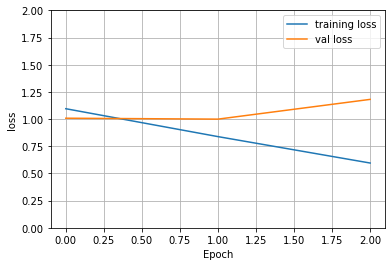

In [52]:
#plot the history
import matplotlib.pyplot as plt
def plot_loss():
  plt.plot([1.0953,0.8387,0.5957], label='training loss')
  plt.plot([1.0080,0.9995,1.1812], label='val loss')
  plt.ylim([0, 2.0])
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.grid(True)
plot_loss()#plot the history


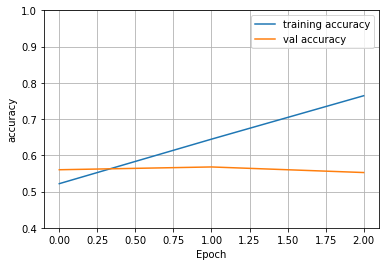

In [53]:
def plot_accuracy():
  plt.plot([0.5218,0.6446,0.7644], label='training accuracy')
  plt.plot([0.5602,0.5679,0.5525], label='val accuracy')
  plt.ylim([0.4, 1.0])
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.grid(True)

plot_accuracy()

In [54]:
#save the model for future usage
rnn_model.save('./rnn_model')


INFO:tensorflow:Assets written to: ./rnn_model/assets


INFO:tensorflow:Assets written to: ./rnn_model/assets


In [55]:
#evaluate the model of testing data
rnn_model.trainable=False

In [56]:
rnn_model.evaluate(X_test,Y_test)

625/625 [==============================] - 95s 140ms/step - loss: 1.2031 - accuracy: 0.5499


[1.203059196472168, 0.5498999953269958]

In [57]:
#find the prediction on testing data for RNN based model
sample_X = X_test[:10]
sample_Y = Y_test[:10]

preds = rnn_model.predict(sample_X)
print(f'the predicted values ={preds}')
print(f'the real values      ={sample_Y}')


the predicted values =[[7.5086852e-04 5.2578381e-04 1.6020637e-02 3.4525824e-01 6.3744444e-01]
 [4.7137719e-06 6.8165389e-07 3.1455656e-05 2.5967925e-04 9.9970347e-01]
 [1.6525127e-02 3.4369044e-02 2.3972724e-01 5.0381911e-01 2.0555948e-01]
 [5.3625256e-03 1.0723502e-02 1.2285347e-01 5.1314527e-01 3.4791529e-01]
 [8.2286177e-05 4.7190128e-06 7.7217454e-05 1.2121792e-02 9.8771393e-01]
 [6.8909754e-03 3.7774277e-01 6.0517180e-01 9.7878501e-03 4.0653866e-04]
 [6.3608000e-03 5.5019379e-01 4.4074118e-01 2.5713646e-03 1.3291200e-04]
 [8.6784907e-02 4.6759319e-01 3.7240869e-01 5.1234875e-02 2.1978296e-02]
 [7.1477087e-05 1.3599664e-04 1.3593421e-02 6.2350088e-01 3.6269835e-01]
 [6.4838088e-01 3.5008878e-01 1.5276672e-03 2.1495425e-06 5.7882897e-07]]
the real values      =[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]]


In [58]:
#calculate the precision,recall,f1 score,confusion matrix for the model
from sklearn.metrics import f1_score,recall_score,precision_score,ConfusionMatrixDisplay

In [59]:
Y_preds = rnn_model.predict(X_test)
print(Y_preds.shape)

(20000, 5)


In [60]:
Y_preds_single = np.argmax(Y_preds,axis=1)
Y_real = np.argmax(Y_test,axis=1)

In [61]:
#plot the f1 score the model across different classes
f1 = f1_score(Y_real,Y_preds_single,average=None)
recall = recall_score(Y_real,Y_preds_single,average=None)
precision = precision_score(Y_real,Y_preds_single,average=None)

In [62]:
print("Weighted F1 Score : ",f1_score(Y_real,Y_preds_single,average="weighted"))
print("Weighted Recall Score : ",recall_score(Y_real,Y_preds_single,average="weighted"))
print("Weighted Precision Score : ",precision_score(Y_real,Y_preds_single,average="weighted"))

Weighted F1 Score :  0.5523903846028141
Weighted Recall Score :  0.5499
Weighted Precision Score :  0.55647906287921


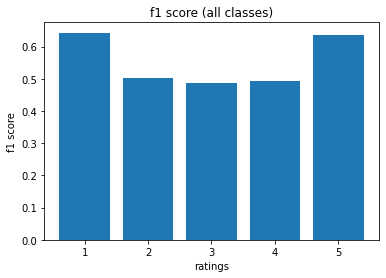

In [63]:
#plot the f1 score
x = [1,2,3,4,5]
plt.bar(x,f1,label='f1 score')
plt.title('f1 score (all classes)')
plt.xlabel('ratings')
plt.ylabel('f1 score')
plt.show()

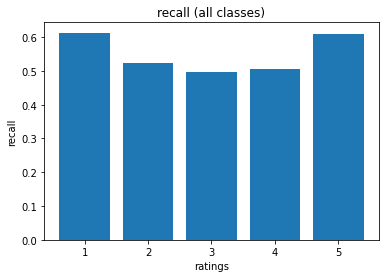

In [64]:
#plot the recall
x = [1,2,3,4,5]
plt.bar(x,recall,label='recall')
plt.title('recall (all classes)')
plt.xlabel('ratings')
plt.ylabel('recall')
plt.show()

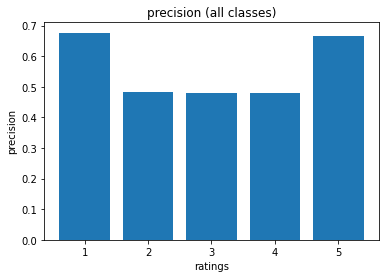

In [65]:
#precision
x = [1,2,3,4,5]
plt.bar(x,precision,label='precision')
plt.title('precision (all classes)')
plt.xlabel('ratings')
plt.ylabel('precision')
plt.show()

In [66]:
#output the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_real,Y_preds_single)
print(cm)

[[2442 1130  234  104   74]
 [ 813 2127  809  207  100]
 [ 220  835 1982  769  183]
 [  72  189  840 2016  872]
 [  63  117  269 1102 2431]]


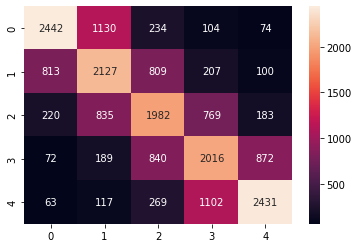

In [67]:
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='g')

In [68]:
#function to test our own statements
import re

values = X_test[:3]
print(values)
preds = rnn_model.predict(values)
print("the number of stars in the process = ",np.argmax(preds,axis=1)+1)
    

['awesome this book is really good   although the tutorials are on you tube having the book in front of me also as a guide has really helped   highly reccomended'
 'five stars great sturdy books   ideal for my 1 year old granddaughter  who loves peppa pig '
 'j adore ce film mais le dvd est de mauvaise qualité car amputé de toute la scène de chasse  je connais parfaitement ce film pour en avoir eu la cassette vidéo et l avoir visionné de multiple fois  j ai voulu acquérir le dvd pour en avoir la version originale  quelle déception il manque toute une partie du film que préconisez vous ']
the number of stars in the process =  [5 5 4]
